In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip --upgrade pip


Usage:   
  pip3 <command> [options]

no such option: --upgrade


In [3]:
! pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.0/165.0 kB 19.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 

In [5]:
# ! pip install geohash2
! pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 5.5 MB/s eta 0:00:00


In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
import shap
import geohash2

In [20]:
!pwd

/content


In [18]:
# Load dataset
# file_path = "./fp-historical-wildfire-data-2006-2023.csv"

file_path="/content/drive/MyDrive/Weather-health/fp-historical-wildfire-data-2006-2023.csv"
data = pd.read_csv(file_path)


# Select columns that have nan value under 3000.
missing_data_count = data.isnull().sum()
valid_columns = [col for col in missing_data_count[missing_data_count < 3000].index.tolist()]

# Selected columns by problem formulation
selected_columns = [
    'fire_location_latitude', 'fire_location_longitude', 'reported_date',
    'dispatch_date', 'start_for_fire_date', 'assessment_datetime',
    'assessment_resource', 'assessment_hectares', 'fire_spread_rate',
    'fire_type', 'fire_position_on_slope', 'weather_conditions_over_fire',
    'temperature', 'relative_humidity', 'wind_direction', 'wind_speed',
    'fuel_type', 'initial_action_by', 'ia_arrival_at_fire_date',
    'fire_fighting_start_date', 'fire_fighting_start_size', 'ia_access',
    'bucketing_on_fire', 'distance_from_water_source', 'ex_fs_date',
    'current_size'
]

# Comparison between valid columns and selected columns
valid_columns_set = set(valid_columns)
selected_columns_set = set(selected_columns)
intersection_columns = valid_columns_set.intersection(selected_columns_set)
missing_columns = selected_columns_set.difference(valid_columns_set)

print("Columns available in both sets:", intersection_columns)
print("Columns missing in the valid columns set:", missing_columns)

# Use intersection of both sets
data_clean = data[list(intersection_columns)].dropna()

# convert the time columns of dataset as datetime type
time_columns = ['reported_date', 'dispatch_date', 'start_for_fire_date', 'assessment_datetime', 'ia_arrival_at_fire_date', 'fire_fighting_start_date', 'ex_fs_date']
timeformat = "%Y-%m-%d %H:%M:%S"

for col in time_columns:
    if col in data_clean.columns:
        data_clean[col] = pd.to_datetime(data_clean[col], format=timeformat)

# Seasonal information
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10]:
        return 'Autumn'
    else:
        return 'Winter'

if 'reported_date' in data_clean.columns:
    data_clean['season'] = data_clean['reported_date'].dt.month.apply(get_season)

# region information by fire number code
region_map = {
    'C': 'Calgary', 'E': 'Edson', 'H': 'High Level', 'G': 'Grande Prairie',
    'L': 'Lac La Biche', 'M': 'Fort McMurray', 'P': 'Peace River',
    'R': 'Rocky', 'S': 'Slave Lake', 'W': 'Whitecourt'
}
if 'fire_number' in data.columns:
    data_clean['fire_region'] = data['fire_number'].str[0].map(region_map)

# Compuation of fire duration time [hour]
data_clean['fire_duration'] = (data_clean['ex_fs_date'] - data_clean['reported_date']).dt.total_seconds() / 3600  # 시간 단위로 변환

# The time gap for dispatch, start-report, and assessment-report [hour]
data_clean["dispatch_gap"] = (
    data_clean["dispatch_date"] - data_clean["reported_date"]
).dt.total_seconds() / 3600.0
data_clean["start_for_fire_gap"] = (
    data_clean["start_for_fire_date"] - data_clean["reported_date"]
).dt.total_seconds() / 3600.0
data_clean["assessment_gap"] = (
    data_clean["assessment_datetime"] - data_clean["reported_date"]
).dt.total_seconds() / 3600.0

for col in time_columns:
    if col in data_clean.columns:
        data_clean[col] = data_clean[col].map(pd.Timestamp.timestamp)

# Encoding categorical variables
categorical_columns = data_clean.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data_clean[col] = le.fit_transform(data_clean[col])
    label_encoders[col] = le

if 'ex_fs_date' in data_clean.columns:
    data_clean.drop(columns=['ex_fs_date'], inplace=True)



Columns available in both sets: {'assessment_resource', 'wind_speed', 'wind_direction', 'fire_type', 'fire_location_longitude', 'assessment_datetime', 'fire_spread_rate', 'fire_position_on_slope', 'initial_action_by', 'assessment_hectares', 'current_size', 'reported_date', 'weather_conditions_over_fire', 'start_for_fire_date', 'fire_location_latitude', 'relative_humidity', 'ex_fs_date', 'temperature', 'dispatch_date'}
Columns missing in the valid columns set: {'ia_access', 'fuel_type', 'fire_fighting_start_date', 'ia_arrival_at_fire_date', 'bucketing_on_fire', 'fire_fighting_start_size', 'distance_from_water_source'}


In [19]:
'''
# Coordinate Information
'''
# Combine latitude and longitude into a single feature
data_clean['coordinates'] = list(zip(data_clean['fire_location_latitude'], data_clean['fire_location_longitude']))

# Drop the original latitude and longitude columns if you no longer need them
data_clean.drop(columns=['fire_location_latitude', 'fire_location_longitude'], inplace=True)
# Apply geohashing
data_clean['geohash'] = data_clean['coordinates'].apply(lambda x: geohash2.encode(x[0], x[1]))

# If needed, you can convert geohash to numerical values (e.g., by taking ASCII values)
data_clean['geohash_num'] = data_clean['geohash'].apply(lambda x: int.from_bytes(x.encode(), 'little'))

# Function to calculate Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius of the Earth in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c
    return distance

# Central point: Edmonton, Alberta coordinates
edmonton_lat, edmonton_lon = 53.5461, -113.4938

# Apply Haversine distance calculation
data_clean['distance_from_edmonton'] = data_clean['coordinates'].apply(lambda x: haversine(edmonton_lat, edmonton_lon, x[0], x[1]))


# If needed, you can now drop the original coordinates column
data_clean.drop(columns=['coordinates'], inplace=True)
data_clean.drop(columns=['geohash'], inplace=True)
#data_clean.drop(columns=['geohash_num'], inplace=True)

# Display the first few rows to verify
print(data_clean[['distance_from_edmonton']].head())


   distance_from_edmonton
0              381.995454
1              160.034175
2              138.852346
3              139.846135
4              376.863680


In [20]:
# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [21]:
y_duration_log = np.log1p(data_clean['fire_duration'] + 1e-9)
y_size_log = np.log1p(data_clean['current_size'] + 1e-9)
#X_log = np.log1p(data_clean.drop(columns=['fire_duration', 'current_size']) + 1e-9)

# Data Normalization
#scaler = StandardScaler()
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(data_clean.drop(columns=['fire_duration', 'current_size']))
y_duration_scaled = scaler.fit_transform(y_duration_log.values.reshape(-1, 1))
y_size_scaled = scaler.fit_transform(y_size_log.values.reshape(-1, 1))


# Create Train and Target Data
X = pd.DataFrame(X_scaled, columns=data_clean.drop(columns=['fire_duration', 'current_size']).columns)
y_duration = pd.DataFrame(y_duration_scaled, columns=['fire_duration'])
y_size = pd.DataFrame(y_size_scaled, columns=['current_size'])

# Split Dataset
X_train, X_test, y_train_duration, y_test_duration = train_test_split(X, y_duration, test_size=0.2, random_state=42)
_, _, y_train_size, y_test_size = train_test_split(X, y_size, test_size=0.2, random_state=42)

# Convert as Tensor for model traning
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_duration_tensor = torch.tensor(y_train_duration.values, dtype=torch.float32).view(-1, 1)
y_test_duration_tensor = torch.tensor(y_test_duration.values, dtype=torch.float32).view(-1, 1)
y_train_size_tensor = torch.tensor(y_train_size.values, dtype=torch.float32).view(-1, 1)
y_test_size_tensor = torch.tensor(y_test_size.values, dtype=torch.float32).view(-1, 1)

# DataLoader
train_dataset_duration = TensorDataset(X_train_tensor, y_train_duration_tensor)
test_dataset_duration = TensorDataset(X_test_tensor, y_test_duration_tensor)

train_dataset_size = TensorDataset(X_train_tensor, y_train_size_tensor)
test_dataset_size = TensorDataset(X_test_tensor, y_test_size_tensor)


In [22]:
print(X_train_tensor.shape)
print(y_train_duration_tensor.shape)
print(y_train_size_tensor.shape)

torch.Size([17958, 22])
torch.Size([17958, 1])
torch.Size([17958, 1])


In [10]:
from pycaret.regression import *


In [25]:

'''
Wild fire duration regression
'''

# PyCaret setup
data_for_pycaret = pd.concat([X, y_duration], axis=1)
duration_reg = setup(data=data_for_pycaret, target='fire_duration', train_size=0.8, session_id=123,experiment_name='fire_duration_regression')

# Model comparison and best model selection
best_model = duration_reg.compare_models()

best_tune = duration_reg.tune_model(best_model)


,Description,Value
0,Session id,123
1,Target,fire_duration
2,Target type,Regression
3,Original data shape,"(22448, 23)"
4,Transformed data shape,"(22448, 23)"
5,Transformed train set shape,"(17958, 23)"
6,Transformed test set shape,"(4490, 23)"
7,Numeric features,22
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.1091,0.0193,0.1390,0.4863,0.1051,0.9876,1.2020
et,Extra Trees Regressor,0.1081,0.0193,0.1390,0.4862,0.1050,0.9237,9.1360
xgboost,Extreme Gradient Boosting,0.1104,0.0203,0.1425,0.4603,0.1076,0.9676,0.3910
rf,Random Forest Regressor,0.1116,0.0203,0.1425,0.4601,0.1077,0.9461,21.3390
gbr,Gradient Boosting Regressor,0.1158,0.0210,0.1447,0.4429,0.1094,1.1398,5.3030
ridge,Ridge Regression,0.1471,0.0314,0.1771,0.1659,0.1346,1.9518,0.0500
br,Bayesian Ridge,0.1469,0.0314,0.1772,0.1655,0.1343,1.9398,0.0340
lr,Linear Regression,0.1468,0.0314,0.1772,0.1648,0.1343,1.9369,0.6440
huber,Huber Regressor,0.1458,0.0326,0.1804,0.1345,0.1338,1.7637,0.2590
knn,K Neighbors Regressor,0.1456,0.0332,0.1821,0.1185,0.1382,1.5379,0.1510


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1140,0.0205,0.1431,0.4350,0.1083,0.9894
1,0.1162,0.0217,0.1474,0.4391,0.1109,1.0072
2,0.1158,0.0209,0.1445,0.4591,0.1090,1.1134
3,0.1144,0.0206,0.1434,0.4468,0.1079,1.2489
4,0.1115,0.0193,0.1388,0.4649,0.1057,0.9417
5,0.1152,0.0208,0.1442,0.4233,0.1104,1.2273
6,0.1192,0.0225,0.1500,0.4043,0.1132,1.1086
7,0.1168,0.0221,0.1486,0.4384,0.1119,0.9920
8,0.1170,0.0223,0.1492,0.4236,0.1113,1.2626


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [27]:
# Best model training and evaluation
final_ML_model_duration = duration_reg.finalize_model(best_tune)

# Model prediction
predictions = duration_reg.predict_model(final_ML_model_duration)
duration_reg.save_model(final_ML_model_duration, '/ML_duration_model')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1007,0.0162,0.1273,0.5714,0.0969,1.0150


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['assessment_resource',
                                              'wind_speed', 'wind_direction',
                                              'fire_type', 'assessment_datetime',
                                              'fire_spread_rate',
                                              'fire_position_on_slope',
                                              'initial_action_by',
                                              'assessment_hectares',
                                              'reported_date',
                                              'weather_conditions_over_fire',
                                              'start_for_fire_date',
                                              'relative_humidity', 'temperature',
                                              'dispatch_date', 'season',
                                              'fire_r

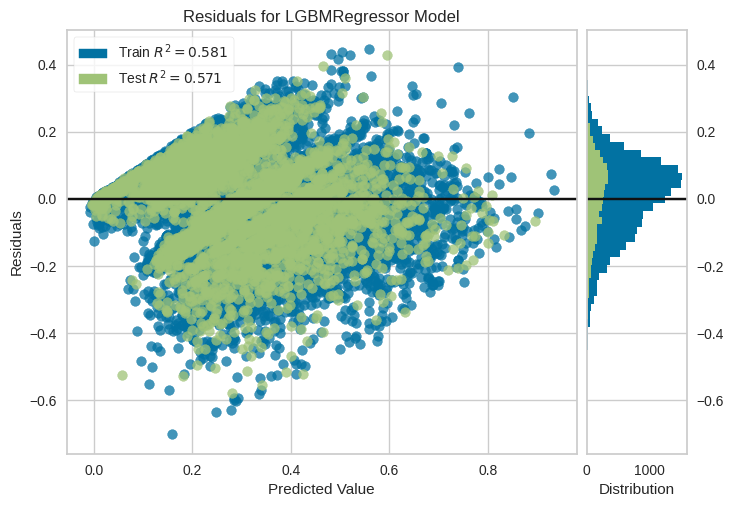

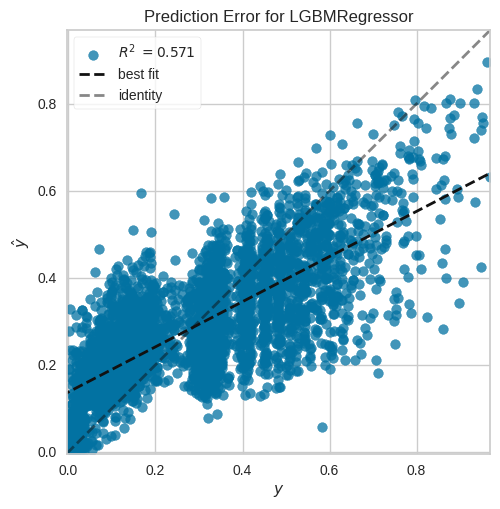

In [14]:
# Model evaluation
plot_model(final_ML_model_duration, plot='residuals')
plot_model(final_ML_model_duration, plot='error')

In [15]:
# R² score

r2 = pull()
print(f"R²of fire duration regression:")
print(r2)

R²of fire duration regression:
                             Model     MAE     MSE    RMSE      R2   RMSLE  \
0  Light Gradient Boosting Machine  0.1007  0.0162  0.1273  0.5714  0.0969   

    MAPE  
0  1.015  


,Description,Value
0,Session id,123
1,Target,fire_duration
2,Target type,Regression
3,Original data shape,"(22448, 23)"
4,Transformed data shape,"(22448, 23)"
5,Transformed train set shape,"(17958, 23)"
6,Transformed test set shape,"(4490, 23)"
7,Numeric features,22
8,Preprocess,True
9,Imputation type,simple


Transformation Pipeline and Model Successfully Loaded


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1007,0.0162,0.1273,0.5714,0.0969,1.0150


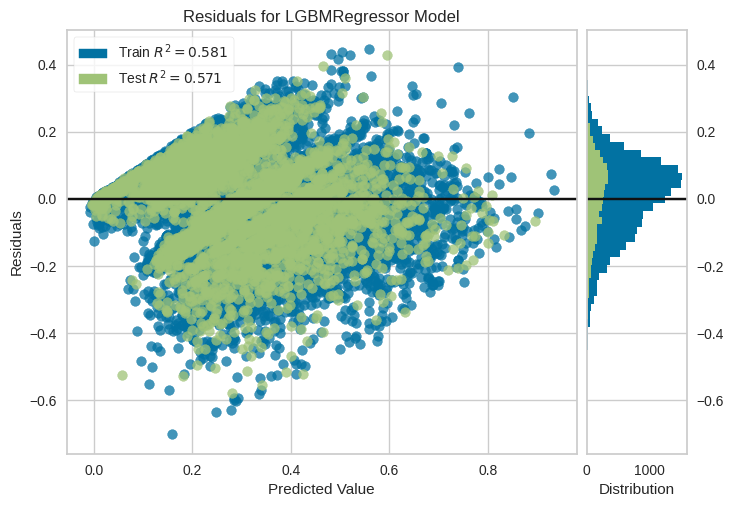

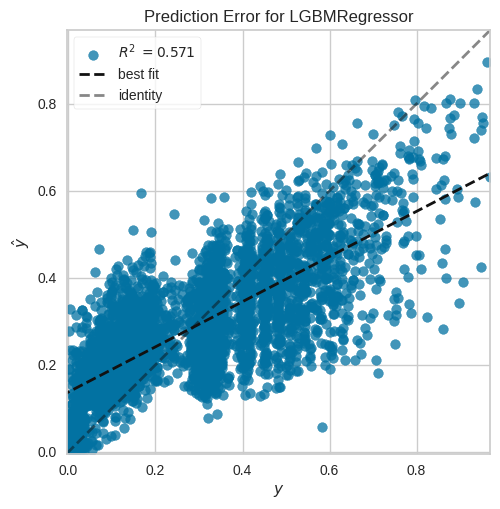

In [34]:
data_for_pycaret = pd.concat([X, y_duration], axis=1)

duration_reg = setup(data=data_for_pycaret, target='fire_duration', train_size=0.8, session_id=123,experiment_name='fire_duration_regression')

ML_duration_model = duration_reg.load_model('/content/drive/MyDrive/ML_duration_model')

predictions = predict_model(ML_duration_model)

plot_model(ML_duration_model, plot='residuals')
plot_model(ML_duration_model, plot='error')


In [32]:
'''
Wild fire size regression
'''

data_for_pycaret = pd.concat([X, y_size], axis=1)
size_reg = setup(data=data_for_pycaret, target='current_size', session_id=123, experiment_name='fire_size_regression')

best_ML_model_size = size_reg.compare_models()

best_ML_tune_size = size_reg.tune_model(best_ML_model_size)



,Description,Value
0,Session id,123
1,Target,current_size
2,Target type,Regression
3,Original data shape,"(22448, 23)"
4,Transformed data shape,"(22448, 23)"
5,Transformed train set shape,"(15713, 23)"
6,Transformed test set shape,"(6735, 23)"
7,Numeric features,22
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.0213,0.0035,0.0589,0.6085,0.0464,1.4242,1.3530
gbr,Gradient Boosting Regressor,0.0219,0.0035,0.0589,0.6083,0.0463,1.6043,4.9080
et,Extra Trees Regressor,0.0223,0.0035,0.0594,0.6019,0.0470,1.8542,6.4040
rf,Random Forest Regressor,0.0224,0.0037,0.0605,0.5873,0.0479,1.6736,19.2800
xgboost,Extreme Gradient Boosting,0.0239,0.0039,0.0624,0.5601,0.0493,1.8443,0.3760
ridge,Ridge Regression,0.0415,0.0064,0.0797,0.2830,0.0644,4.8047,0.0510
br,Bayesian Ridge,0.0408,0.0064,0.0798,0.2820,0.0640,4.6797,0.0330
lr,Linear Regression,0.0408,0.0064,0.0798,0.2813,0.0640,4.6736,0.5530
huber,Huber Regressor,0.0313,0.0073,0.0853,0.1785,0.0685,1.7422,0.2540
dt,Decision Tree Regressor,0.0292,0.0076,0.0868,0.1506,0.0679,1.8298,0.2690


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0231,0.0036,0.0601,0.5731,0.0473,1.8201
1,0.0248,0.0047,0.0689,0.5204,0.0533,1.9198
2,0.0236,0.0035,0.0592,0.6036,0.0469,1.9115
3,0.0232,0.0036,0.0602,0.5679,0.0476,1.8520
4,0.0217,0.0035,0.0589,0.5867,0.0462,1.8397
5,0.0225,0.0037,0.0609,0.5701,0.0475,1.8049
6,0.0237,0.0042,0.0648,0.5956,0.0501,1.5008
7,0.0226,0.0035,0.0596,0.5597,0.0475,1.7842
8,0.0246,0.0043,0.0657,0.5638,0.0518,1.7955


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [35]:
final_ML_model_size = size_reg.finalize_model(best_ML_model_size)

predictions = size_reg.predict_model(final_ML_model_size)


size_reg.save_model(final_ML_model_size, '/ML_size_model')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0162,0.0019,0.0434,0.7900,0.0343,1.1677


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['assessment_resource',
                                              'wind_speed', 'wind_direction',
                                              'fire_type', 'assessment_datetime',
                                              'fire_spread_rate',
                                              'fire_position_on_slope',
                                              'initial_action_by',
                                              'assessment_hectares',
                                              'reported_date',
                                              'weather_conditions_over_fire',
                                              'start_for_fire_date',
                                              'relative_humidity', 'temperature',
                                              'dispatch_date', 'season',
                                              'fire_r

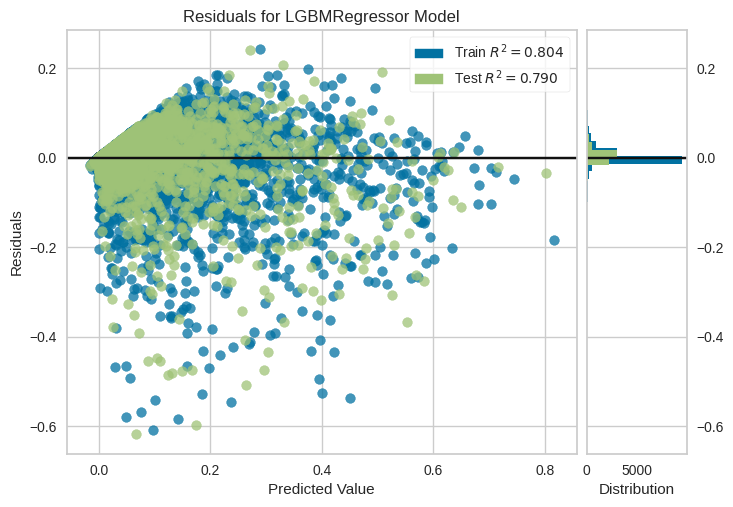

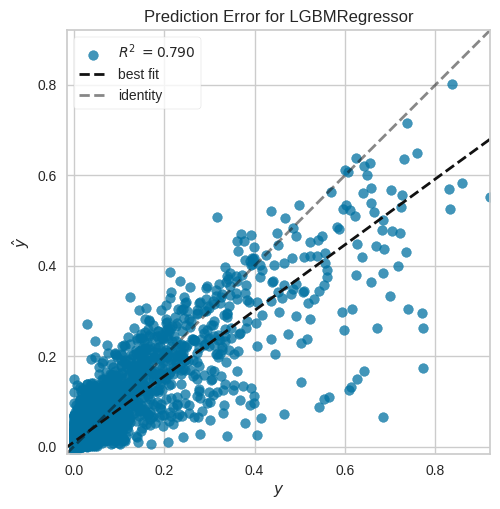

In [18]:

plot_model(final_ML_model_size, plot='residuals')
plot_model(final_ML_model_size, plot='error')


In [19]:
r2 = pull()
print(f"R²of fire size regression:")
print(r2)

R²of fire size regression:
                             Model     MAE     MSE    RMSE    R2   RMSLE  \
0  Light Gradient Boosting Machine  0.0162  0.0019  0.0434  0.79  0.0343   

     MAPE  
0  1.1677  


Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


,Description,Value
0,Session id,123
1,Target,current_size
2,Target type,Regression
3,Original data shape,"(22448, 23)"
4,Transformed data shape,"(22448, 23)"
5,Transformed train set shape,"(15713, 23)"
6,Transformed test set shape,"(6735, 23)"
7,Numeric features,22
8,Preprocess,True
9,Imputation type,simple


Transformation Pipeline and Model Successfully Loaded


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0162,0.0019,0.0434,0.7900,0.0343,1.1677


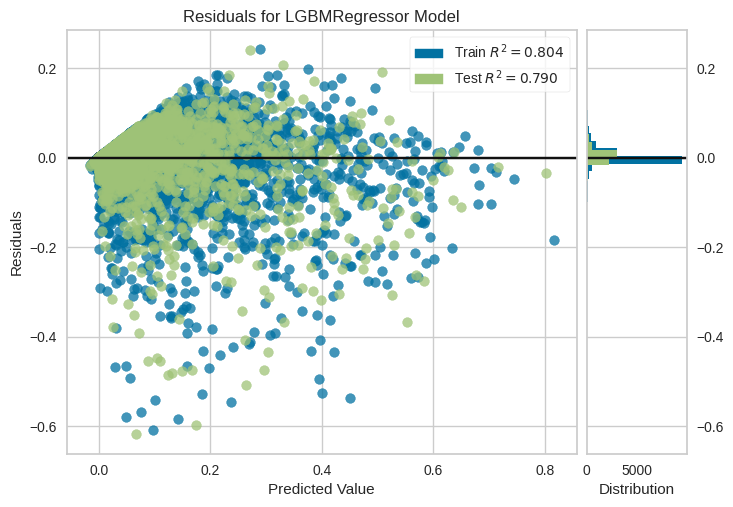

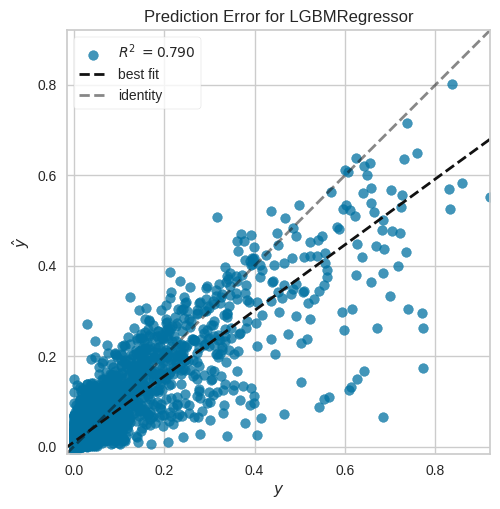

In [38]:
data_for_pycaret = pd.concat([X, y_size], axis=1)
size_reg = setup(data=data_for_pycaret, target='current_size', session_id=123, experiment_name='fire_size_regression')

ML_size_model = size_reg.load_model('/content/drive/MyDrive/ML_size_model')


predictions = predict_model(ML_size_model)
plot_model(ML_size_model, plot='residuals')
plot_model(ML_size_model, plot='error')




In [40]:
train_pipe = ML_size_model[:-1].transform(X)

explainer = shap.TreeExplainer(ML_size_model.named_steps["actual_estimator"])

shap_values = explainer.shap_values(X)

In [ ]:
house_idx = 0
shap.force_plot(explainer.expected_value, shap_values[house_idx,:], train_pipe.iloc[house_idx,:])

shap.force_plot(explainer.expected_value, shap_values, train_pipe)


In [ ]:
'''
Feed Forward Model
'''
class SimpleFirePredictionModel(nn.Module):
    def __init__(self, input_dim,dropout_rate=0.3):
        super(SimpleFirePredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
'''
Convolution + Long Short Term Memory Model
(CNN + LSTM)
'''
class CNNLSTMModel(nn.Module):
    def __init__(self, input_dim,dropout_rate=0.3):
        super(CNNLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.lstm = nn.LSTM(input_size=32, hidden_size=64, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch_size, 1, seq_length)
        x = self.pool(torch.relu((self.conv1(x))))  # (batch_size, 32, seq_length/2)
        x = x.permute(0, 2, 1)  # (batch_size, seq_length/2, 32)
        x, _ = self.lstm(x)  # (batch_size, seq_length/2, 64)
        x = self.dropout(torch.relu(self.fc1(x[:, -1, :])))  # (batch_size, 32)
        x = self.fc2(x)  # (batch_size, 1)
        return x



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from itertools import product

# Combined loss function
def combined_loss(output, target):
    mse_loss = nn.MSELoss()(output, target)
    l1_loss = nn.L1Loss()(output, target)
    return mse_loss + l1_loss


# Hyperparameter tuning function
def hyperparameter_tuning(model_type:str, target_type:str,train_dataset,test_dataset,criterion, param_dist, n_iter=20):
    def create_model(lr, dropout):
        if model_type == "FNN":
            model = SimpleFirePredictionModel(input_dim=X_train.shape[1], dropout_rate=dropout).to(device)
        elif model_type == "CNNLSTM":
            model = CNNLSTMModel(input_dim=X_train.shape[1], dropout_rate=dropout).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        return model, optimizer

    # Custom Scoring Function
    def custom_scorer(model, data_loader):
        model.eval()
        actuals = []
        predictions = []
        with torch.no_grad():
            for inputs, targets in data_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                actuals.extend(targets.cpu().numpy())
                predictions.extend(outputs.cpu().numpy())
        mse = mean_squared_error(actuals, predictions)
        mae = np.mean(np.abs(np.array(actuals) - np.array(predictions)))
        r2 = r2_score(actuals, predictions)
        return r2, np.array(actuals), np.array(predictions)

    best_params = None
    best_score = float('-inf')
    num_epochs=100
    for params in param_grid:
        lr, dropout, bs = params
        train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)
        model, optimizer = create_model(lr, dropout)
        print(f"Current Parameters of {model_type} for Wildfire {target_type} Prediction: ['lr':{params[0]}, 'dropout':{params[1]}, 'batch_size':{params[2]}]")

        train_losses=[]
        # Train the model
        for epoch in range(num_epochs):
            running_loss = 0.0
            model.train()
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            epoch_loss = running_loss / len(train_loader)
            train_losses.append(epoch_loss)
            if (epoch+1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

        score, _, _ = custom_scorer(model,test_loader)
        print("R2 score of FNN for Wildfire Prediction: %.4f \n"%score)

        if score > best_score:
            best_score = score
            best_params = {'lr':lr, 'dropout':dropout, 'batch_size':bs}
            torch.save(model.state_dict(),'best_{}_{}_model.pt'.format(model_type, target_type))

    return best_params, best_score

# Define the parameter grid
param_grid = list(product(
    [0.01, 0.001, 0.0001],
    [0.0, 0.2, 0.3],
    [32, 64, 128]
))

# param_dist = {
#     'lr': [0.01, 0.001, 0.0001],
#     'dropout': [0.0, 0.2, 0.3]
# }


In [ ]:
# Model evaluation code
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    actuals = []
    predictions = []
    # MAE = []
    # MSE = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            actuals.extend(targets.cpu().numpy())
            predictions.extend(outputs.cpu().numpy())
    avg_loss = total_loss / len(test_loader)
    # actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()
    # predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    return avg_loss, np.array(actuals), np.array(predictions)

# visualization
def plot_predictions(actuals, predictions, title):
    plt.figure(figsize=(5, 5))
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'k--', lw=2)
    plt.title(title)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.show()

# R² score
def calculate_score(actuals, predictions, title):
    mse = mean_squared_error(actuals, predictions)
    mae = np.mean(np.abs(np.array(actuals) - np.array(predictions)))
    r2 = r2_score(actuals, predictions)
    print(f'\n{title} - MAE: {mae:.4f}')
    print(f'\n{title} - MSE: {mse:.4f}')
    print(f'\n{title} - R²: {r2:.4f}')


In [ ]:
# Perform hyperparameter tuning
model_type = "FNN"
target_type = "duration"
best_params, best_score = hyperparameter_tuning(model_type,target_type,train_dataset_duration, test_dataset_duration,combined_loss, param_grid)
print(f"Best Parameters of FNN for Wildfire Duration Prediction: {best_params}")
print("Best R2 score of FNN for Wildfire Duration Prediction: %.4f"%best_score)



Current Parameters of FNN for Wildfire duration Prediction: ['lr':0.01, 'dropout':0.0, 'batch_size':32]
Epoch [10/100], Loss: 0.1645
Epoch [20/100], Loss: 0.1620
Epoch [30/100], Loss: 0.1603
Epoch [40/100], Loss: 0.1567
Epoch [50/100], Loss: 0.1530
Epoch [60/100], Loss: 0.1517
Epoch [70/100], Loss: 0.1493
Epoch [80/100], Loss: 0.1492
Epoch [90/100], Loss: 0.1500
Epoch [100/100], Loss: 0.1496
R2 score of FNN for Wildfire Prediction: 0.3038 

Current Parameters of FNN for Wildfire duration Prediction: ['lr':0.01, 'dropout':0.0, 'batch_size':64]
Epoch [10/100], Loss: 0.1610
Epoch [20/100], Loss: 0.1558
Epoch [30/100], Loss: 0.1544
Epoch [40/100], Loss: 0.1522
Epoch [50/100], Loss: 0.1509
Epoch [60/100], Loss: 0.1519
Epoch [70/100], Loss: 0.1488
Epoch [80/100], Loss: 0.1490
Epoch [90/100], Loss: 0.1474
Epoch [100/100], Loss: 0.1474
R2 score of FNN for Wildfire Prediction: 0.3280 

Current Parameters of FNN for Wildfire duration Prediction: ['lr':0.01, 'dropout':0.0, 'batch_size':128]
Epoch


 Wildfire Duration Model - Loss: 0.1433


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

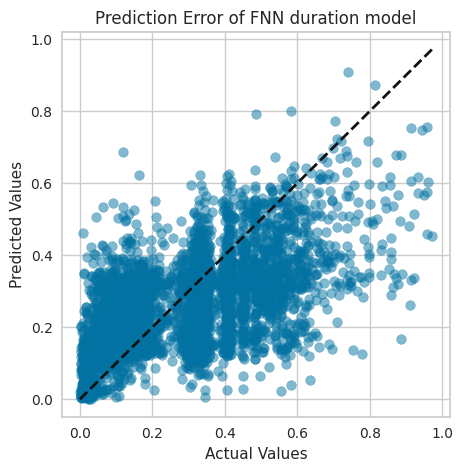


Score of Fire Duration Model (FNN) - MAE: 0.1190

Score of Fire Duration Model (FNN) - MSE: 0.0243

Score of Fire Duration Model (FNN) - R²: 0.3290


In [ ]:
model_duration = SimpleFirePredictionModel(input_dim=X_train.shape[1], dropout_rate=best_params['dropout']).to(device)
model_duration.load_state_dict(torch.load("best_{}_{}_model.pt".format(model_type,target_type)))
# train_loader_duration = DataLoader(train_dataset_duration, batch_size=best_params['batch_size'], shuffle=True)
test_loader_duration = DataLoader(test_dataset_duration, batch_size=best_params['batch_size'], shuffle=False)

duration_loss, actuals_duration, predictions_duration = evaluate_model(model_duration, test_loader_duration, combined_loss)
print("\n Wildfire Duration Model - Loss: %.4f"%duration_loss)

# # Comparision of ground truth and prediction (Wildfire duration)
plot_predictions(actuals_duration, predictions_duration, 'Prediction Error of FNN duration model')
calculate_score(actuals_duration, predictions_duration, 'Score of Fire Duration Model (FNN)')

In [ ]:
# Perform hyperparameter tuning
model_type = "FNN"
target_type = "size"
best_params, best_score = hyperparameter_tuning(model_type,target_type,train_dataset_size, test_dataset_size,combined_loss, param_grid)
print(f"Best Parameters of FNN for Wildfire Size Prediction: {best_params}")
print("Best R2 score of FNN for Wildfire Size Prediction: %.4f"%best_score)


Current Parameters of FNN for Wildfire size Prediction: ['lr':0.01, 'dropout':0.0, 'batch_size':32]
Epoch [10/100], Loss: 0.0368
Epoch [20/100], Loss: 0.0361
Epoch [30/100], Loss: 0.0359
Epoch [40/100], Loss: 0.0352
Epoch [50/100], Loss: 0.0347
Epoch [60/100], Loss: 0.0345
Epoch [70/100], Loss: 0.0344
Epoch [80/100], Loss: 0.0343
Epoch [90/100], Loss: 0.0342
Epoch [100/100], Loss: 0.0342
R2 score of FNN for Wildfire Prediction: 0.3689 

Current Parameters of FNN for Wildfire size Prediction: ['lr':0.01, 'dropout':0.0, 'batch_size':64]
Epoch [10/100], Loss: 0.0359
Epoch [20/100], Loss: 0.0349
Epoch [30/100], Loss: 0.0336
Epoch [40/100], Loss: 0.0328
Epoch [50/100], Loss: 0.0326
Epoch [60/100], Loss: 0.0311
Epoch [70/100], Loss: 0.0307
Epoch [80/100], Loss: 0.0309
Epoch [90/100], Loss: 0.0301
Epoch [100/100], Loss: 0.0295
R2 score of FNN for Wildfire Prediction: 0.4217 

Current Parameters of FNN for Wildfire size Prediction: ['lr':0.01, 'dropout':0.0, 'batch_size':128]
Epoch [10/100], L

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo


 Wildfire Size Model - Loss: 0.0313


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

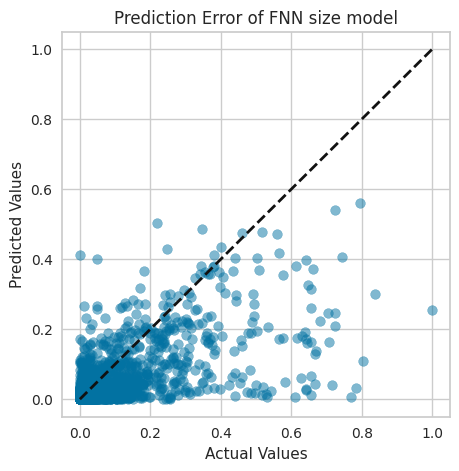


Score of Fire Size Model (FNN) - MAE: 0.0265

Score of Fire Size Model (FNN) - MSE: 0.0052

Score of Fire Size Model (FNN) - R²: 0.4323


In [ ]:


model_size = SimpleFirePredictionModel(input_dim=X_train.shape[1], dropout_rate=best_params['dropout']).to(device)
model_size.load_state_dict(torch.load("best_{}_{}_model.pt".format(model_type,target_type)))
# train_loader_size = DataLoader(train_dataset_size, batch_size=best_params['batch_size'], shuffle=True)
test_loader_size = DataLoader(test_dataset_size, batch_size=best_params['batch_size'], shuffle=False)

size_loss, actuals_size, predictions_size = evaluate_model(model_size, test_loader_size, combined_loss)
print("\n Wildfire Size Model - Loss: %.4f"%size_loss)

# # Comparision of ground truth and prediction (Wildfire size)
plot_predictions(actuals_size, predictions_size, 'Prediction Error of FNN size model')
calculate_score(actuals_size, predictions_size, 'Score of Fire Size Model (FNN)')

In [ ]:
# Perform hyperparameter tuning
model_type = "CNNLSTM"
target_type = "duration"
best_params, best_score = hyperparameter_tuning(model_type,target_type,train_dataset_duration, test_dataset_duration,combined_loss, param_grid)
print(f"Best Parameters of CNNLSTM for Wildfire Duration Prediction: {best_params}")
print("Best R2 score of CNNLSTM for Wildfire Duration Prediction: %.4f"%best_score)

Current Parameters of CNNLSTM for Wildfire duration Prediction: ['lr':0.01, 'dropout':0.0, 'batch_size':32]
Epoch [10/100], Loss: 0.1686
Epoch [20/100], Loss: 0.1540
Epoch [30/100], Loss: 0.1491
Epoch [40/100], Loss: 0.1451
Epoch [50/100], Loss: 0.1410
Epoch [60/100], Loss: 0.1393
Epoch [70/100], Loss: 0.1353
Epoch [80/100], Loss: 0.1332
Epoch [90/100], Loss: 0.1328
Epoch [100/100], Loss: 0.1292
R2 score of FNN for Wildfire Prediction: 0.2546 

Current Parameters of CNNLSTM for Wildfire duration Prediction: ['lr':0.01, 'dropout':0.0, 'batch_size':64]
Epoch [10/100], Loss: 0.1651
Epoch [20/100], Loss: 0.1484
Epoch [30/100], Loss: 0.1381
Epoch [40/100], Loss: 0.1254
Epoch [50/100], Loss: 0.1168
Epoch [60/100], Loss: 0.1082
Epoch [70/100], Loss: 0.1005
Epoch [80/100], Loss: 0.0946
Epoch [90/100], Loss: 0.0897
Epoch [100/100], Loss: 0.0855
R2 score of FNN for Wildfire Prediction: 0.1397 

Current Parameters of CNNLSTM for Wildfire duration Prediction: ['lr':0.01, 'dropout':0.0, 'batch_size

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif



 Wildfire Duration Model - Loss: 0.1483


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

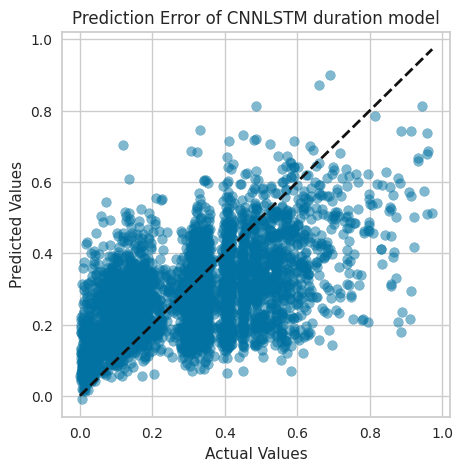


Score of Fire Duration Model (CNNLSTM) - MAE: 0.1234

Score of Fire Duration Model (CNNLSTM) - MSE: 0.0247

Score of Fire Duration Model (CNNLSTM) - R²: 0.3174


In [ ]:
model_duration_CNNLSTM = CNNLSTMModel(input_dim=X_train.shape[1], dropout_rate=best_params['dropout']).to(device)
model_duration_CNNLSTM.load_state_dict(torch.load("best_{}_{}_model.pt".format(model_type,target_type)))
# train_loader_duration = DataLoader(train_dataset_duration, batch_size=best_params['batch_size'], shuffle=True)
test_loader_duration = DataLoader(test_dataset_duration, batch_size=best_params['batch_size'], shuffle=False)

duration_loss, actuals_duration, predictions_duration = evaluate_model(model_duration_CNNLSTM, test_loader_duration, combined_loss)
print("\n Wildfire Duration Model - Loss: %.4f"%duration_loss)

# # Comparision of ground truth and prediction (Wildfire duration)
plot_predictions(actuals_duration, predictions_duration, 'Prediction Error of CNNLSTM duration model')
calculate_score(actuals_duration, predictions_duration, 'Score of Fire Duration Model (CNNLSTM)')

In [ ]:
# Perform hyperparameter tuning
model_type = "CNNLSTM"
target_type = "size"
best_params, best_score = hyperparameter_tuning(model_type,target_type,train_dataset_size, test_dataset_size,combined_loss, param_grid)
print(f"Best Parameters of CNNLSTM for Wildfire Size Prediction: {best_params}")
print("Best R2 score of CNNLSTM for Wildfire Size Prediction: %.4f"%best_score)


Current Parameters of CNNLSTM for Wildfire size Prediction: ['lr':0.01, 'dropout':0.0, 'batch_size':32]
Epoch [10/100], Loss: 0.0467
Epoch [20/100], Loss: 0.0467
Epoch [30/100], Loss: 0.0466
Epoch [40/100], Loss: 0.0467
Epoch [50/100], Loss: 0.0466
Epoch [60/100], Loss: 0.0465
Epoch [70/100], Loss: 0.0467
Epoch [80/100], Loss: 0.0466
Epoch [90/100], Loss: 0.0467
Epoch [100/100], Loss: 0.0466
R2 score of FNN for Wildfire Prediction: -0.1077 

Current Parameters of CNNLSTM for Wildfire size Prediction: ['lr':0.01, 'dropout':0.0, 'batch_size':64]
Epoch [10/100], Loss: 0.0394
Epoch [20/100], Loss: 0.0343
Epoch [30/100], Loss: 0.0326
Epoch [40/100], Loss: 0.0320
Epoch [50/100], Loss: 0.0304
Epoch [60/100], Loss: 0.0292
Epoch [70/100], Loss: 0.0288
Epoch [80/100], Loss: 0.0276
Epoch [90/100], Loss: 0.0269
Epoch [100/100], Loss: 0.0269
R2 score of FNN for Wildfire Prediction: 0.3089 

Current Parameters of CNNLSTM for Wildfire size Prediction: ['lr':0.01, 'dropout':0.0, 'batch_size':128]
Epoc

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo


 Wildfire Size Model - Loss: 0.0345


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

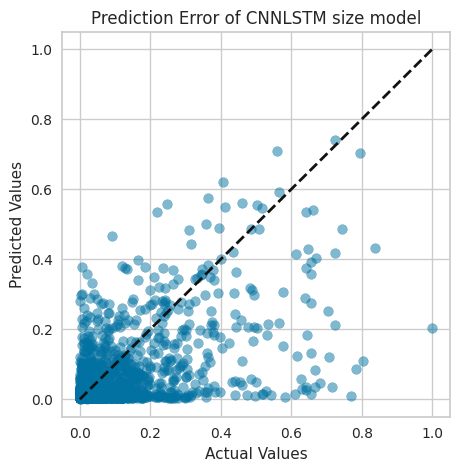


Score of Fire Size Model (CNNLSTM) - MAE: 0.0294

Score of Fire Size Model (CNNLSTM) - MSE: 0.0057

Score of Fire Size Model (CNNLSTM) - R²: 0.3843


In [ ]:
model_size_CNNLSTM = CNNLSTMModel(input_dim=X_train.shape[1], dropout_rate=best_params['dropout']).to(device)
model_size_CNNLSTM.load_state_dict(torch.load("best_{}_{}_model.pt".format(model_type,target_type)))

# train_loader_size = DataLoader(train_dataset_size, batch_size=best_params['batch_size'], shuffle=True)
test_loader_size = DataLoader(test_dataset_size, batch_size=best_params['batch_size'], shuffle=False)

size_loss, actuals_size, predictions_size = evaluate_model(model_size_CNNLSTM, test_loader_size, combined_loss)
print("\n Wildfire Size Model - Loss: %.4f"%size_loss)

# Comparision of ground truth and prediction (Wildfire size)
plot_predictions(actuals_size, predictions_size, 'Prediction Error of CNNLSTM size model')
calculate_score(actuals_size, predictions_size, 'Score of Fire Size Model (CNNLSTM)')

In [ ]:
# Model training code
def train_model(model, train_loader, criterion, optimizer, num_epochs=100):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            # loss = criterion(outputs, targets)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    return model, train_losses






Feedforward Neural Network (FNN)

 Training duration model...
Epoch [5/100], Loss: 0.1741
Epoch [10/100], Loss: 0.1653
Epoch [15/100], Loss: 0.1607
Epoch [20/100], Loss: 0.1577
Epoch [25/100], Loss: 0.1548
Epoch [30/100], Loss: 0.1535
Epoch [35/100], Loss: 0.1514
Epoch [40/100], Loss: 0.1501
Epoch [45/100], Loss: 0.1482
Epoch [50/100], Loss: 0.1471
Epoch [55/100], Loss: 0.1463
Epoch [60/100], Loss: 0.1448
Epoch [65/100], Loss: 0.1432
Epoch [70/100], Loss: 0.1440
Epoch [75/100], Loss: 0.1427
Epoch [80/100], Loss: 0.1432
Epoch [85/100], Loss: 0.1419
Epoch [90/100], Loss: 0.1414
Epoch [95/100], Loss: 0.1406
Epoch [100/100], Loss: 0.1410

 Evaluating wildfire duration model...

 Wildfire Duration Model - Loss: 0.1456


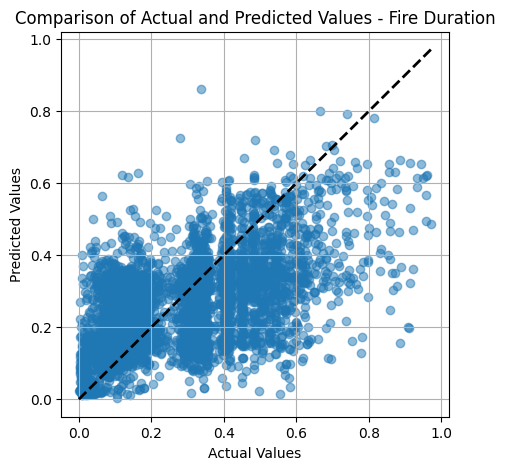


Score of Fire Duration Model (FNN) - MAE: 0.1202

Score of Fire Duration Model (FNN) - MSE: 0.0253

Score of Fire Duration Model (FNN) - R²: 0.3023


In [ ]:
# Model Initialization
input_dim = X_train_tensor.shape[1]
# print(f"Input dimension: {input_dim}")

print("Feedforward Neural Network (FNN)")

model_duration = SimpleFirePredictionModel(input_dim,dropout_rate=0.2).to(device)
optimizer_duration = optim.Adam(model_duration.parameters(), lr=0.001)

# Wildfire duration prediction model training
print("\n Training duration model...")
model_duration, train_losses_duration = train_model(model_duration, train_loader_duration, combined_loss, optimizer_duration)

print("\n Evaluating wildfire duration model...")
duration_loss, actuals_duration, predictions_duration = evaluate_model(model_duration, test_loader_duration, combined_loss)
print("\n Wildfire Duration Model - Loss: %.4f"%duration_loss )

# Comparision of ground truth and prediction (Wildfire duration)
plot_predictions(actuals_duration, predictions_duration, 'Comparison of Actual and Predicted Values - Fire Duration')
calculate_score(actuals_duration, predictions_duration, 'Score of Fire Duration Model (FNN)')



 Training size model...
Epoch [5/100], Loss: 0.0372
Epoch [10/100], Loss: 0.0353
Epoch [15/100], Loss: 0.0349
Epoch [20/100], Loss: 0.0343
Epoch [25/100], Loss: 0.0336
Epoch [30/100], Loss: 0.0329
Epoch [35/100], Loss: 0.0325
Epoch [40/100], Loss: 0.0324
Epoch [45/100], Loss: 0.0324
Epoch [50/100], Loss: 0.0321
Epoch [55/100], Loss: 0.0317
Epoch [60/100], Loss: 0.0312
Epoch [65/100], Loss: 0.0314
Epoch [70/100], Loss: 0.0308
Epoch [75/100], Loss: 0.0303
Epoch [80/100], Loss: 0.0305
Epoch [85/100], Loss: 0.0300
Epoch [90/100], Loss: 0.0296
Epoch [95/100], Loss: 0.0302
Epoch [100/100], Loss: 0.0294

 Evaluating wildfire size model...
MAE: 0.0272
MSE: 0.0045

 Wildfire Size Model - Loss: 0.0317


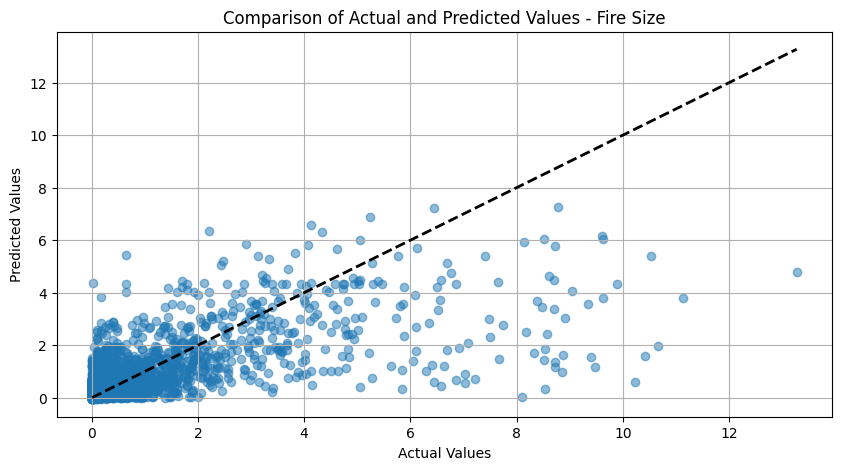


R²score of Fire Size Model (FNN) - R²: 0.5101


In [ ]:
model_size = SimpleFirePredictionModel(input_dim, dropout_rate=0.0).to(device)

# Optimizer
optimizer_size = optim.Adam(model_size.parameters(), lr=0.01)

# Wildfire size prediction model training
print("\n Training size model...")
model_size, train_losses_size = train_model(model_size, train_loader_size, combined_loss, optimizer_size)



 Training size model...
Epoch [5/100], Loss: 0.0379
Epoch [10/100], Loss: 0.0361
Epoch [15/100], Loss: 0.0362
Epoch [20/100], Loss: 0.0351
Epoch [25/100], Loss: 0.0353
Epoch [30/100], Loss: 0.0351
Epoch [35/100], Loss: 0.0343
Epoch [40/100], Loss: 0.0339
Epoch [45/100], Loss: 0.0338
Epoch [50/100], Loss: 0.0337
Epoch [55/100], Loss: 0.0336
Epoch [60/100], Loss: 0.0338
Epoch [65/100], Loss: 0.0337
Epoch [70/100], Loss: 0.0330
Epoch [75/100], Loss: 0.0330
Epoch [80/100], Loss: 0.0328
Epoch [85/100], Loss: 0.0325
Epoch [90/100], Loss: 0.0327
Epoch [95/100], Loss: 0.0326
Epoch [100/100], Loss: 0.0324

 Evaluating wildfire size model...

 Wildfire Size Model - Loss: 0.0355


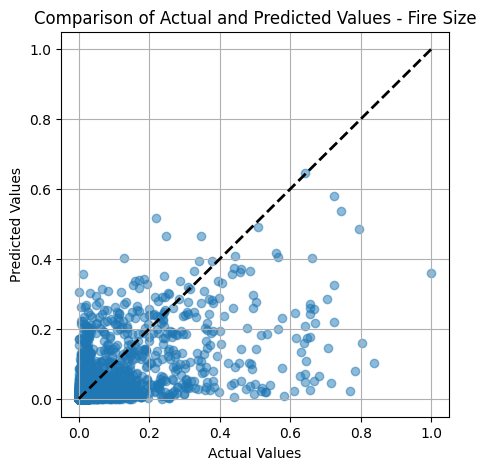


Score of Fire Size Model (FNN) - MAE: 0.0299

Score of Fire Size Model (FNN) - MSE: 0.0058

Score of Fire Size Model (FNN) - R²: 0.3654


In [ ]:
model_size = SimpleFirePredictionModel(input_dim, dropout_rate=0.0).to(device)

# Optimizer
optimizer_size = optim.Adam(model_size.parameters(), lr=0.01)

# Wildfire size prediction model training
print("\n Training size model...")
model_size, train_losses_size = train_model(model_size, train_loader_size, combined_loss, optimizer_size)
print("\n Evaluating wildfire size model...")
size_loss, actuals_size, predictions_size = evaluate_model(model_size, test_loader_size, combined_loss)
print("\n Wildfire Size Model - Loss: %.4f"%size_loss)

# # Comparision of ground truth and prediction (Wildfire size)
plot_predictions(actuals_size, predictions_size, 'Comparison of Actual and Predicted Values - Fire Size')
calculate_score(actuals_size, predictions_size, 'Score of Fire Size Model (FNN)')

Model: CNN(Convolutional Neural Network)+ LSTM(Long Short Term Memory)

 Training duration CNNLSTM model...
Epoch [5/100], Loss: 0.1935
Epoch [10/100], Loss: 0.1775
Epoch [15/100], Loss: 0.1714
Epoch [20/100], Loss: 0.1693
Epoch [25/100], Loss: 0.1663
Epoch [30/100], Loss: 0.1648
Epoch [35/100], Loss: 0.1613
Epoch [40/100], Loss: 0.1594
Epoch [45/100], Loss: 0.1566
Epoch [50/100], Loss: 0.1558
Epoch [55/100], Loss: 0.1546
Epoch [60/100], Loss: 0.1546
Epoch [65/100], Loss: 0.1535
Epoch [70/100], Loss: 0.1520
Epoch [75/100], Loss: 0.1515
Epoch [80/100], Loss: 0.1495
Epoch [85/100], Loss: 0.1492
Epoch [90/100], Loss: 0.1475
Epoch [95/100], Loss: 0.1456
Epoch [100/100], Loss: 0.1450

 Evaluating wildfire duration CNNLSTM model...

 Wildfire CNNLSTMDuration Model - Loss: 0.1491


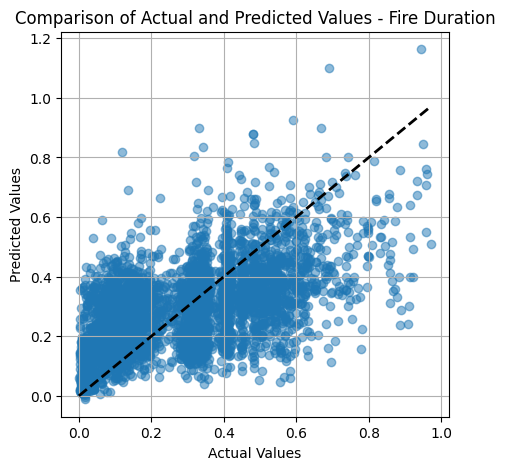


Score of Fire Duration Model (CNNLSTM) - MAE: 0.1238

Score of Fire Duration Model (CNNLSTM) - MSE: 0.0253

Score of Fire Duration Model (CNNLSTM) - R²: 0.3015


In [ ]:
print("Model: CNN(Convolutional Neural Network)+ LSTM(Long Short Term Memory)")

input_dim = X_train_tensor.shape[1]


# Model Initialization
model_duration_cnnlstm = CNNLSTMModel(input_dim,dropout_rate=0.3).to(device)
# Optimizer
optimizer_duration_cnnlstm = optim.Adam(model_duration_cnnlstm.parameters(), lr=0.001)


# Wildfire duration prediction model training
print("\n Training duration CNNLSTM model...")
model_duration, train_losses_duration = train_model(model_duration_cnnlstm, train_loader_duration, combined_loss, optimizer_duration_cnnlstm, num_epochs=100)

print("\n Evaluating wildfire duration CNNLSTM model...")
duration_loss, actuals_duration, predictions_duration = evaluate_model(model_duration_cnnlstm, test_loader_duration, combined_loss)
print("\n Wildfire CNNLSTMDuration Model - Loss: %.4f"%duration_loss )

# Comparision of ground truth and prediction (Wildfire duration)
plot_predictions(actuals_duration, predictions_duration, 'Comparison of Actual and Predicted Values - Fire Duration')
calculate_score(actuals_duration, predictions_duration, 'Score of Fire Duration Model (CNNLSTM)')



 Training size CNNLSTM model...
Epoch [5/100], Loss: 0.0466
Epoch [10/100], Loss: 0.0457
Epoch [15/100], Loss: 0.0431
Epoch [20/100], Loss: 0.0408
Epoch [25/100], Loss: 0.0395
Epoch [30/100], Loss: 0.0386
Epoch [35/100], Loss: 0.0385
Epoch [40/100], Loss: 0.0377
Epoch [45/100], Loss: 0.0370
Epoch [50/100], Loss: 0.0369
Epoch [55/100], Loss: 0.0363
Epoch [60/100], Loss: 0.0360
Epoch [65/100], Loss: 0.0355
Epoch [70/100], Loss: 0.0355
Epoch [75/100], Loss: 0.0345
Epoch [80/100], Loss: 0.0341
Epoch [85/100], Loss: 0.0336
Epoch [90/100], Loss: 0.0337
Epoch [95/100], Loss: 0.0327
Epoch [100/100], Loss: 0.0324

 Evaluating wildfire size CNNLSTM model...

 Wildfire CNNLSTM Size Model - Loss: 0.0396


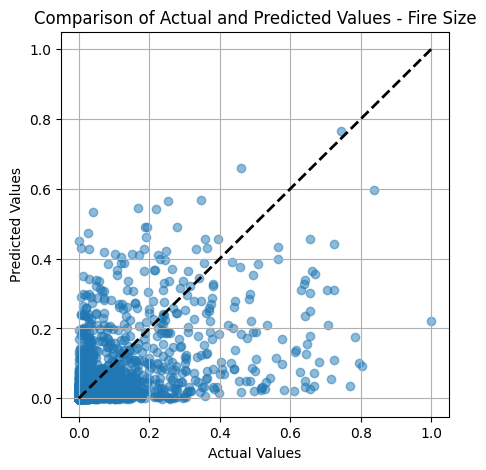


Score of Fire Size Model (CNNLSTM - MAE: 0.0331

Score of Fire Size Model (CNNLSTM - MSE: 0.0067

Score of Fire Size Model (CNNLSTM - R²: 0.2723


In [ ]:
model_size_cnnlstm  = CNNLSTMModel(input_dim,dropout_rate=0.0).to(device)
optimizer_size_cnnlstm = optim.Adam(model_size_cnnlstm.parameters(), lr=0.001)

# Wildfire size prediction model training
print("\n Training size CNNLSTM model...")
model_size, train_losses_size = train_model(model_size_cnnlstm, train_loader_size, combined_loss, optimizer_size_cnnlstm, num_epochs=100)

print("\n Evaluating wildfire size CNNLSTM model...")
size_loss, actuals_size, predictions_size = evaluate_model(model_size_cnnlstm, test_loader_size, combined_loss)
print("\n Wildfire CNNLSTM Size Model - Loss: %.4f"%size_loss)

# # Comparision of ground truth and prediction (Wildfire size)
plot_predictions(actuals_size, predictions_size, 'Comparison of Actual and Predicted Values - Fire Size')
calculate_score(actuals_size, predictions_size,  'Score of Fire Size Model (CNNLSTM')

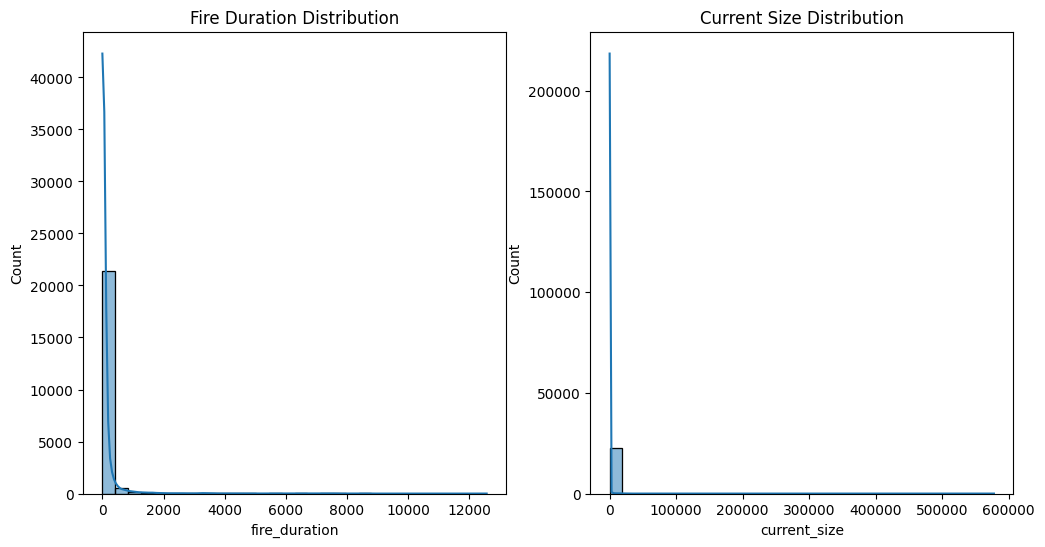

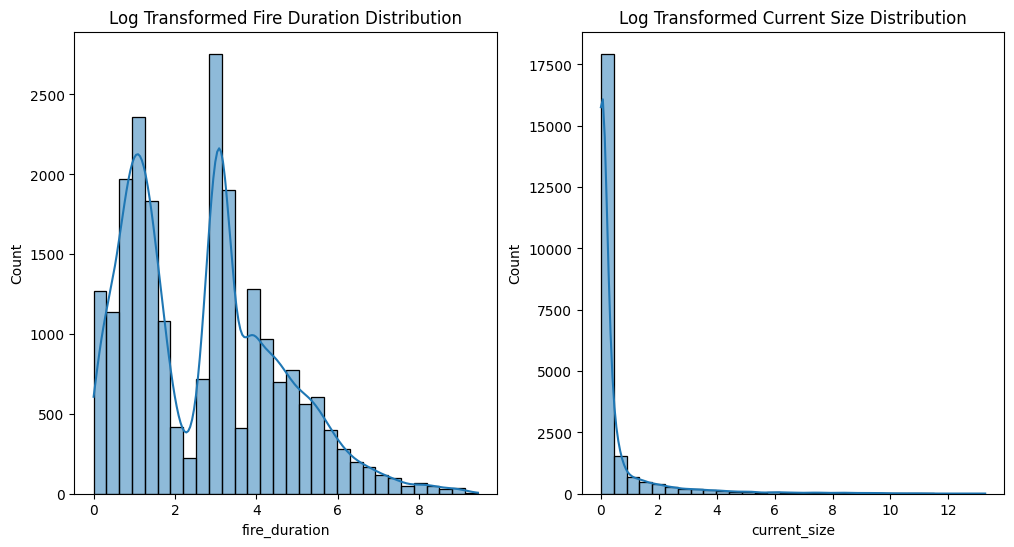

In [ ]:
import seaborn as sns

# Distribution of Target features
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data_clean['fire_duration'], bins=30, kde=True)
plt.title('Fire Duration Distribution')

plt.subplot(1, 2, 2)
sns.histplot(data_clean['current_size'], bins=30, kde=True)
plt.title('Current Size Distribution')

plt.show()

# Distribution of Target features after log transformation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(np.log1p(data_clean['fire_duration'] + 1e-9), bins=30, kde=True)
plt.title('Log Transformed Fire Duration Distribution')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(data_clean['current_size'] + 1e-9), bins=30, kde=True)
plt.title('Log Transformed Current Size Distribution')

plt.show()


In [ ]:
import shap

# SHAP을 사용한 특징 중요도 분석
def shap_feature_importance(model, data, title):
    # SHAP explainer 초기화
    explainer = shap.DeepExplainer(model, data.to(device))
    shap_values = explainer.shap_values(data.to(device))

    # 특징 중요도 시각화
    shap.summary_plot(shap_values, data.cpu(), plot_type="bar", feature_names=data.columns, show=False)
    plt.title(title)
    plt.show()

# SHAP 분석을 위한 모델 래핑 (PyTorch 모델)
class WrappedModel(nn.Module):
    def __init__(self, model):
        super(WrappedModel, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

# SHAP 분석 수행
wrapped_model_duration = WrappedModel(model_duration)
wrapped_model_size = WrappedModel(model_size)

shap_feature_importance(wrapped_model_duration, X_test_tensor, 'Feature Importance - Fire Duration')
shap_feature_importance(wrapped_model_size, X_test_tensor, 'Feature Importance - Fire Size')


 Training size CNNLSTM_skip model...
Epoch [5/100], Loss: 0.1366
Epoch [10/100], Loss: 0.1354
Epoch [15/100], Loss: 0.1353
Epoch [20/100], Loss: 0.1367
Epoch [25/100], Loss: 0.1357
Epoch [30/100], Loss: 0.1357
Epoch [35/100], Loss: 0.1355
Epoch [40/100], Loss: 0.1364
Epoch [45/100], Loss: 0.1359
Epoch [50/100], Loss: 0.1361
Epoch [55/100], Loss: 0.1369
Epoch [60/100], Loss: 0.1357
Epoch [65/100], Loss: 0.1357
Epoch [70/100], Loss: 0.1352
Epoch [75/100], Loss: 0.1358
Epoch [80/100], Loss: 0.1344
Epoch [85/100], Loss: 0.1358
Epoch [90/100], Loss: 0.1352
Epoch [95/100], Loss: 0.1367
Epoch [100/100], Loss: 0.1355

 Evaluating wildfire size CNNLSTM_skip model...
MAE: 0.0925
MSE: 0.0178

 Wildfire CNNLSTM Size Model - Loss: 0.1103


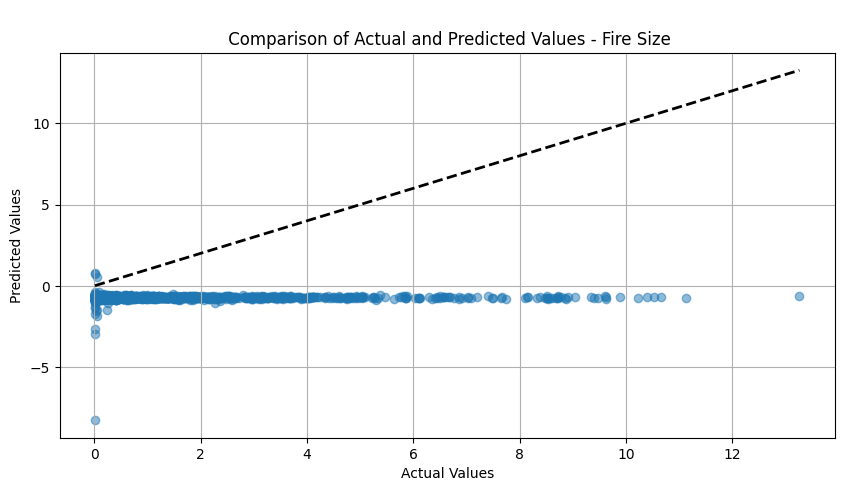



 R²score of Fire Size Model (CNNLSTM - R²: -0.9432


In [ ]:
# 모델 초기화
input_dim = X_train_tensor.shape[1]
model_duration_cnnlstm_skip = CNNLSTMModelWithSkip(input_dim).to(device)

# Loss function
criterion =[nn.L1Loss(), nn.MSELoss()]

# Optimizer
optimizer_duration_cnnlstm_skip = optim.Adam(model_duration_cnnlstm_skip.parameters(), lr=0.001)

model_size_cnnlstm_skip  = CNNLSTMModelWithSkip(input_dim).to(device)
optimizer_size_cnnlstm_skip = optim.Adam(model_size_cnnlstm_skip.parameters(), lr=0.001)

# Wildfire size prediction model training
print("\n Training size CNNLSTM_skip model...")
model_size, train_losses_size = train_model(model_size_cnnlstm_skip, train_loader_size, criterion, optimizer_size_cnnlstm)

print("\n Evaluating wildfire size CNNLSTM_skip model...")
size_loss, actuals_size, predictions_size = evaluate_model(model_size_cnnlstm_skip, test_loader_size, criterion)
print("\n Wildfire CNNLSTM Size Model - Loss: %.4f"%size_loss)

# # Comparision of ground truth and prediction (Wildfire size)
plot_predictions(actuals_size, predictions_size, '\n Comparison of Actual and Predicted Values - Fire Size')
calculate_r2(actuals_size, predictions_size,  '\n R²score of Fire Size Model (CNNLSTM')